In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from datetime import date
from datetime import datetime
import scipy.stats

# Lectura de datos de COVID-19

In [10]:
# Lectura de datos
DataSource='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/'
DataFileDUS='master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv' #Muertes en Estados unidos
DataFileCUS='master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv' #Casos confirmados en estados unidos

cvaDUS = pd.read_csv('{}{}'.format(DataSource,DataFileDUS))
cvaCUS = pd.read_csv('{}{}'.format(DataSource,DataFileCUS))

In [11]:
# Obtencion de fecha del día de ayer para iniciar análisis con datos del último día
d = date.today()
AYER = str(d.month)+'/'+str(d.day-1)+'/'+str(d.year)[-2:]
AYER

'5/11/20'

In [12]:
# Datos provistos por CSSE de la universidad de Johns Hopkins
print('Casos hasta ayer en USA:',cvaCUS[AYER].sum(),'\nMuertes hasta ayer en USA:',cvaDUS[AYER].sum())

Casos hasta ayer en USA: 1347881 
Muertes hasta ayer en USA: 80682


# Limpieza de datos de COVID-19

In [13]:
# Limpieza de datos para obtenes solo casos dentro de estados federales 
COVCases = pd.DataFrame(cvaCUS.dropna().set_index(['Province_State','Admin2'])[AYER])
COVCases.columns = ['CASOS']

COVDeaths = pd.DataFrame(cvaDUS.dropna().set_index(['Province_State','Admin2'])[AYER])
COVDeaths.columns = ['MUERTES']

# Eliminar datos que categorizados como 'Unassigned'
COV = pd.merge(COVCases, COVDeaths, how = 'inner', left_index=True, right_index=True)
print('Casos sin asignar que se eliminaron:\n'+str(COV.xs('Unassigned', level='Admin2').sum()))
COV = COV.drop('Unassigned', level='Admin2')
COV.index.names = ['Estado', 'Condado']
COV

Casos sin asignar que se eliminaron:
CASOS      3363
MUERTES     843
dtype: int64


CASOS  MUERTES
Estado        Condado                  
Alabama       Autauga       84        4
              Baldwin      224        6
              Barbour       61        1
              Bibb          46        1
              Blount        45        0
...                        ...      ...
Virginia      Out of VA      0        0
Washington    Out of WA      0        0
West Virginia Out of WV      0        0
Wisconsin     Out of WI      0        0
Wyoming       Out of WY      0        0

[3193 rows x 2 columns]

# Cálculo de Mortalidad
$$ Mortalidad = \frac{Muertes}{Casos}  $$

In [14]:
COV['MORTALIDAD'] = COV['MUERTES']/COV['CASOS']
COV.head()
COV = COV.reset_index()
COV.head()

,Estado,Condado,CASOS,MUERTES,MORTALIDAD
0,Alabama,Autauga,84,4,0.047619
1,Alabama,Baldwin,224,6,0.026786
2,Alabama,Barbour,61,1,0.016393
3,Alabama,Bibb,46,1,0.021739
4,Alabama,Blount,45,0,0.000000


# Lectura de datos de PM2.5
Fuente: EPA
#### ESTE ES EL PASO  MAS LARGO

In [15]:
Directorio = 'DatosPM2.5/'
almacenarVar = False


PM25 = pd.DataFrame()
for i in range(51):
    #Lectura para datos promedios mensuales para cada condado
    PMC = (pd.read_csv(Directorio+'ad_viz_plotval_data ('+str(i+1)+').csv')
                                   .set_index(['STATE','COUNTY'])[['Date','Daily Mean PM2.5 Concentration','DAILY_AQI_VALUE']]
                                   .apply(lambda df : pd.Series({'Año':int(df['Date'][-2:]),'Mes': int(df['Date'][0:2]),'Date':df.Date,'PM 2.5':df['Daily Mean PM2.5 Concentration'],'AQI':df.DAILY_AQI_VALUE}),axis = 1)
                                   .groupby(['STATE','COUNTY','Mes','Año'])
                                   .mean())
    
    PMC19 = (pd.read_csv(Directorio+'ad_viz_plotval_data ('+str(i+1)+')2019.csv')
                                   .set_index(['STATE','COUNTY'])[['Date','Daily Mean PM2.5 Concentration','DAILY_AQI_VALUE']]
                                   .apply(lambda df : pd.Series({'Año':int(df['Date'][-2:]),'Mes': int(df['Date'][0:2]),'Date':df.Date,'PM 2.5':df['Daily Mean PM2.5 Concentration'],'AQI':df.DAILY_AQI_VALUE}),axis = 1)
                                   .groupby(['STATE','COUNTY','Mes','Año'])
                                   .mean())
    
    # Paso opcional por si se quiere almacenar en variables diferentes cada información por estado
    if almacenarVar:
        estado = str(PMC.index[0][0])
        estado = estado.split()
        if len(estado)>1:
            estado = [estado[0]+'_'+estado[1]]
        estado = estado[0]
        globals()['PM_%s'%estado]=PMC
    
    PM25 = PM25.append(PMC)
    PM25 = PM25.append(PMC19)
    
PM25 = PM25.reset_index()
PM25

,STATE,COUNTY,Mes,Año,PM 2.5,AQI
0,Alabama,Jefferson,1,20,7.636364,31.248485
1,Alabama,Jefferson,2,20,7.312057,29.921986
2,Alabama,Jefferson,3,20,9.279221,37.305195
3,Alabama,Jefferson,4,20,9.146000,36.933333
4,Alabama,Jefferson,5,20,10.206667,42.200000
...,...,...,...,...,...,...
11656,Wyoming,Teton,8,19,3.343662,14.000000
11657,Wyoming,Teton,9,19,2.444286,10.214286
11658,Wyoming,Teton,10,19,1.638298,6.914894
11659,Wyoming,Teton,11,19,1.283333,5.583333


# Unión de datos de COVID y PM2.5

In [16]:
COVyPM25 = pd.merge(COV, PM25, how='inner', left_on=['Estado','Condado'], right_on=['STATE', 'COUNTY']).set_index(['Estado','Condado']).drop(['STATE','COUNTY'], axis=1)

TakeNAas0 = True

if TakeNAas0:
    COVyPM25[np.isnan(COVyPM25['MORTALIDAD'])]=0 #Reemplazo valores en donde no hay ni casos ni muertes como mortalidad = 0
else:
    COVyPM25.dropna(inplace=True)

print('Cantidad de observaciones =',len(COVyPM25))
print('Cantidad de condados con observaciones =', len(COVyPM25.groupby('Condado').mean()))

print(COVyPM25.head())

R6 = COVyPM25[((COVyPM25.Mes <= 3) & (COVyPM25['Año'] == 20))|((COVyPM25.Mes > 9) & (COVyPM25['Año'] == 19))].reset_index().groupby(['Estado','Condado']).mean()

S = []
C = []

for i in R6.index:
    S.append(i[0])
    C.append(i[1])

R6 = R6.reset_index()

R6.to_excel('ResultadosSemestral'+str(date.today())+'.xlsx')

R3 = COVyPM25[((COVyPM25.Mes <= 3) & (COVyPM25['Año'] == 20))].reset_index().groupby(['Estado','Condado']).mean()

S = []
C = []

for i in R3.index:
    S.append(i[0])
    C.append(i[1])

R3 = R3.reset_index()

R3.to_excel('ResultadosTrimestral'+str(date.today())+'.xlsx')

Cantidad de observaciones = 11475
Cantidad de condados con observaciones = 611
                 CASOS  MUERTES  MORTALIDAD  Mes  Año  PM 2.5     AQI
Estado  Condado                                                      
Alabama Baldwin    224        6    0.026786    1   19  6.8250  28.375
        Baldwin    224        6    0.026786    2   19  6.8375  28.500
        Baldwin    224        6    0.026786    3   19  7.5300  31.300
        Baldwin    224        6    0.026786    4   19  6.2750  26.250
        Baldwin    224        6    0.026786    5   19  6.5875  27.500


# Obtención de matrices de correlación

KendalltauResult(correlation=0.10909048452799934, pvalue=9.864022247483575e-05)
SpearmanrResult(correlation=0.1614186044354782, pvalue=8.31855892780199e-05)
KendalltauResult(correlation=0.15290037519959443, pvalue=7.04482001564721e-08)
SpearmanrResult(correlation=0.22222088359854875, pvalue=7.455302463869224e-08)
KendalltauResult(correlation=0.16245467324199944, pvalue=2.0847023752221934e-08)
SpearmanrResult(correlation=0.2444151693553488, pvalue=6.150656772947311e-09)
KendalltauResult(correlation=0.11414547455134508, pvalue=1.7823975775107903e-05)
SpearmanrResult(correlation=0.17137711093084204, pvalue=1.0161004803842013e-05)
KendalltauResult(correlation=0.13709291042191366, pvalue=2.44962919831153e-07)
SpearmanrResult(correlation=0.20291979510393557, pvalue=1.5208491075513916e-07)
KendalltauResult(correlation=0.1327867737592133, pvalue=5.838006682375042e-07)
SpearmanrResult(correlation=0.19400070895851634, pvalue=5.419271893297384e-07)


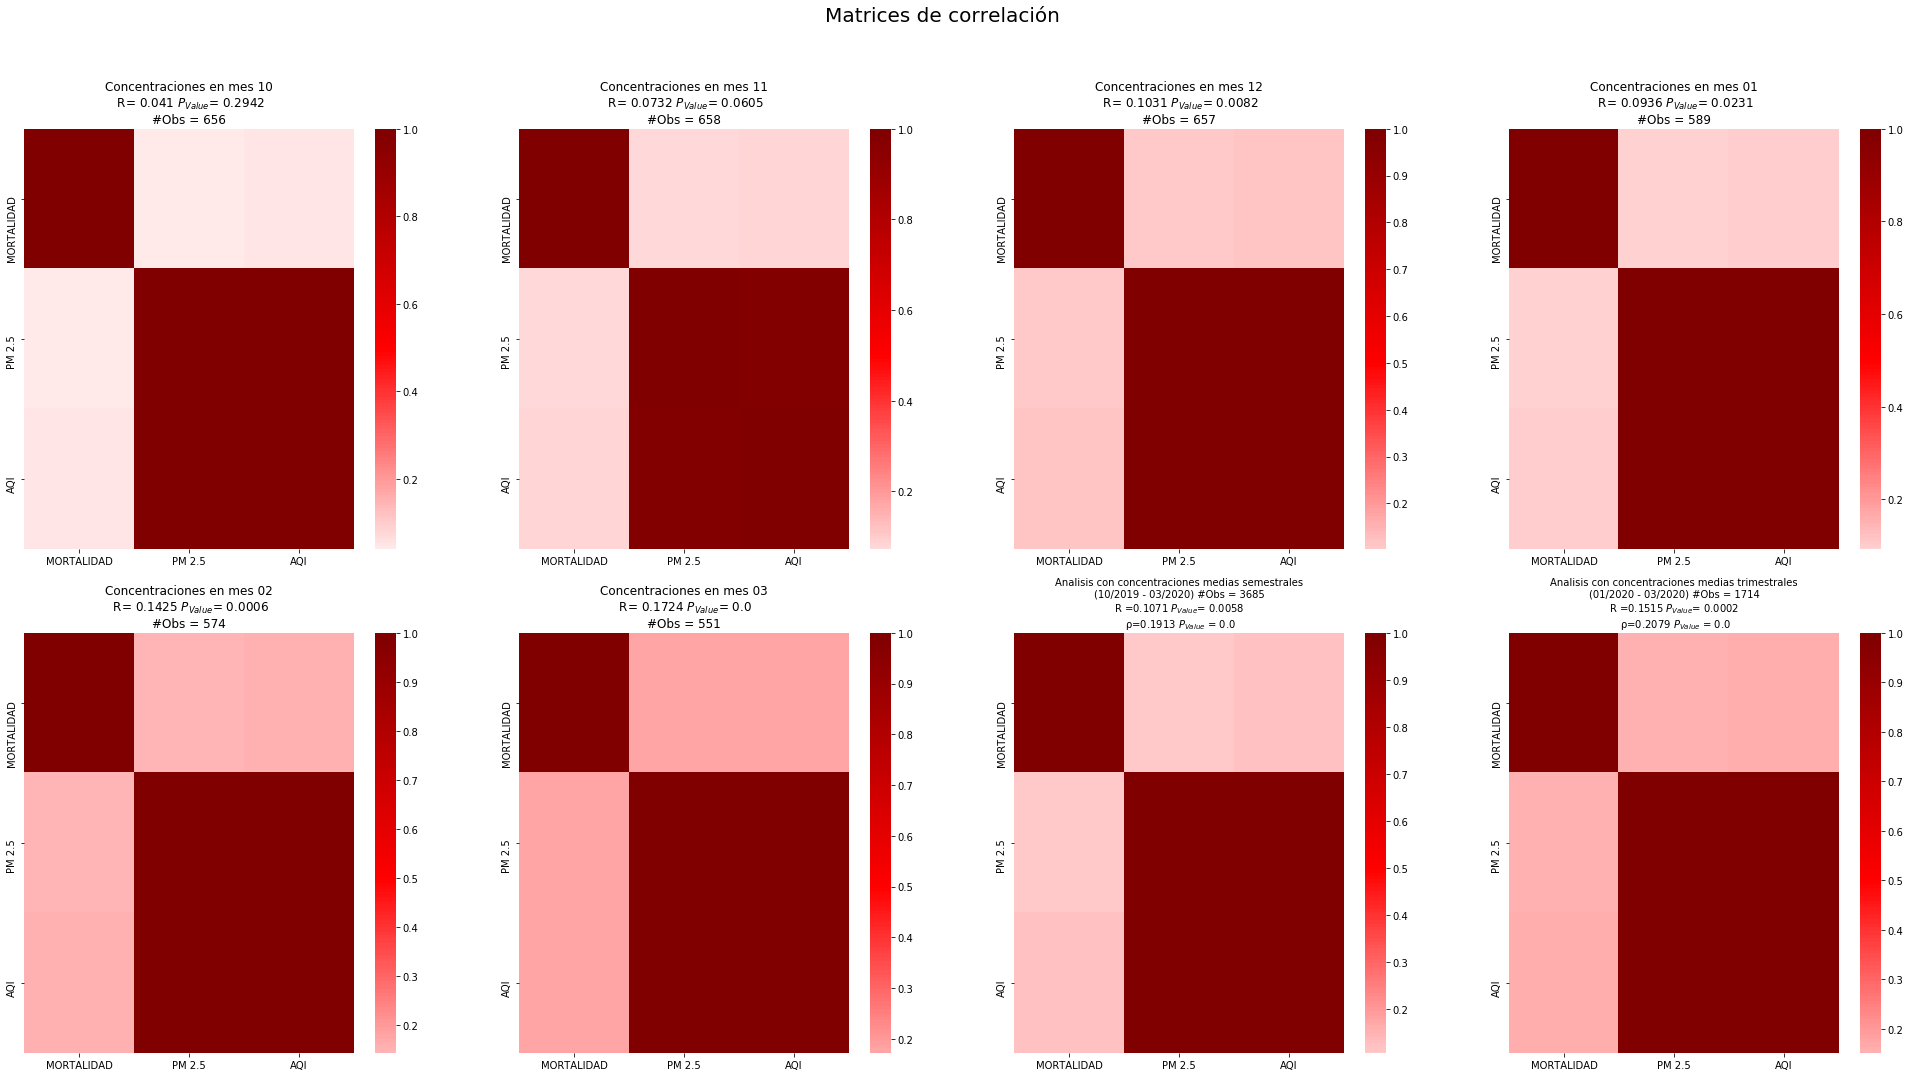

In [17]:
fig = plt.figure(figsize=(34,17))



plt.suptitle('Matrices de correlación', fontsize=20)

for i in range(3):
    plt.subplot(2,4,i+4)
    
    # Obtencion R Pearson y P-Value
    R, PVal = scipy.stats.pearsonr(COVyPM25[(COVyPM25.Mes == i+1)&(COVyPM25['Año'] == 20)]['MORTALIDAD'],COVyPM25[(COVyPM25.Mes == i+1)&(COVyPM25['Año'] == 20)]['PM 2.5']) 
    print(scipy.stats.kendalltau(COVyPM25[(COVyPM25.Mes == i+1)&(COVyPM25['Año'] == 20)]['MORTALIDAD'],COVyPM25[(COVyPM25.Mes == i+1)&(COVyPM25['Año'] == 20)]['PM 2.5']))
    print(scipy.stats.spearmanr(COVyPM25[(COVyPM25.Mes == i+1)&(COVyPM25['Año'] == 20)]['MORTALIDAD'],COVyPM25[(COVyPM25.Mes == i+1)&(COVyPM25['Año'] == 20)]['PM 2.5']))
    
    # Matriz de correlacion mes i
    (sns.heatmap(
        COVyPM25[(COVyPM25.Mes == i+1)&(COVyPM25['Año'] == 20)]
        .drop(['Mes','Año','CASOS','MUERTES'],axis=1)
        .corr(),
        cmap = 'seismic',
        center=0))
    plt.title('Concentraciones en mes 0'+str(i+1)+'\n R= '+str(round(R,4))+' $P_{Value}$= '+str(round(PVal,4))+'\n#Obs = '+ str(len(COVyPM25[(COVyPM25.Mes == i+1)&(COVyPM25['Año'] == 20)])))
    
for i in range(10,13):
    plt.subplot(2,4,i-9)
    
    # Obtencion R Pearson y P-Value
    R, PVal = scipy.stats.pearsonr(COVyPM25[(COVyPM25.Mes == i)&(COVyPM25['Año'] == 19)]['MORTALIDAD'],COVyPM25[(COVyPM25.Mes == i)&(COVyPM25['Año'] == 19)]['PM 2.5']) 
    print(scipy.stats.kendalltau(COVyPM25[(COVyPM25.Mes == i)&(COVyPM25['Año'] == 19)]['MORTALIDAD'],COVyPM25[(COVyPM25.Mes == i)&(COVyPM25['Año'] == 19)]['PM 2.5']))
    print(scipy.stats.spearmanr(COVyPM25[(COVyPM25.Mes == i)&(COVyPM25['Año'] == 19)]['MORTALIDAD'],COVyPM25[(COVyPM25.Mes == i)&(COVyPM25['Año'] == 19)]['PM 2.5']))
    
    # Matriz de correlacion mes i
    (sns.heatmap(
        COVyPM25[(COVyPM25.Mes == i)&(COVyPM25['Año'] == 19)]
        .drop(['Mes','Año','CASOS','MUERTES'],axis=1)
        .corr(),
        cmap = 'seismic',
        center=0))
    plt.title('Concentraciones en mes '+str(i)+'\n R= '+str(round(R,4))+' $P_{Value}$= '+str(round(PVal,4))+'\n#Obs = '+ str(len(COVyPM25[(COVyPM25.Mes == i)&(COVyPM25['Año'] == 19)])))
    
plt.subplot(247)

COVyPM6Month = COVyPM25[((COVyPM25.Mes <= 3) & (COVyPM25['Año'] == 20))|((COVyPM25.Mes > 9) & (COVyPM25['Año'] == 19))]

R, PVal = scipy.stats.pearsonr(COVyPM6Month.groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)['MORTALIDAD'],
                               COVyPM6Month.groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)['PM 2.5']) 
rho, Pvalrho = scipy.stats.spearmanr(COVyPM6Month['MORTALIDAD'],COVyPM6Month['PM 2.5'])

# print(scipy.stats.spearmanr(COVyPM6Month['MORTALIDAD'],COVyPM6Month['AQI']))

(sns.heatmap(
    COVyPM6Month
    .groupby(['Estado','Condado'])
    .mean()
    .drop(['Mes','Año','CASOS','MUERTES'],axis=1)
    .corr(),
    cmap = 'seismic',
    center=0))

plt.title('Analisis con concentraciones medias semestrales\n(10/2019 - 03/2020) #Obs = '+ str(len(COVyPM6Month)) + '\nR ='
          + str(round(R,4)) + ' $P_{Value}$= '+str(round(PVal,4))
          +'\n \u03C1='+str(round(rho,4)) + ' $P_{Value}$ = '+ str(round(Pvalrho,4))
          , fontsize=10)

plt.subplot(248)

COVyPM3Month = COVyPM25[((COVyPM25.Mes <= 3) & (COVyPM25['Año'] == 20))]

R, PVal = scipy.stats.pearsonr(COVyPM3Month.groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)['MORTALIDAD'],
                               COVyPM3Month.groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)['PM 2.5']) 
rho, Pvalrho = scipy.stats.spearmanr(COVyPM3Month['MORTALIDAD'],COVyPM3Month['PM 2.5'])

# print(scipy.stats.spearmanr(COVyPM3Month['MORTALIDAD'],COVyPM3Month['AQI']))

(sns.heatmap(
    COVyPM3Month
    .groupby(['Estado','Condado'])
    .mean()
    .drop(['Mes','Año','CASOS','MUERTES'],axis=1)
    .corr(),
    cmap = 'seismic',
    center=0))

plt.title('Analisis con concentraciones medias trimestrales\n(01/2020 - 03/2020) #Obs = '+ str(len(COVyPM3Month)) + '\nR ='
          + str(round(R,4)) + ' $P_{Value}$= '+str(round(PVal,4))
          +'\n \u03C1='+str(round(rho,4)) + ' $P_{Value}$ = '+ str(round(Pvalrho,4))
          ,fontsize=10)


fig.savefig('MatrizDeCorrelacionDeCadaMes'+str(date.today())+'.png', dpi=100)

                 CASOS  MUERTES  MORTALIDAD    PM 2.5        AQI
Estado  Condado                                                 
Alabama Baldwin  224.0      6.0    0.026786  6.820278  28.188889
        Clay      27.0      1.0    0.037037  6.198333  25.616667
        DeKalb   158.0      2.0    0.012658  6.478056  27.138889
        Etowah   193.0     10.0    0.051813  8.142130  32.487037
        Houston  107.0      4.0    0.037383  7.260833  30.041667


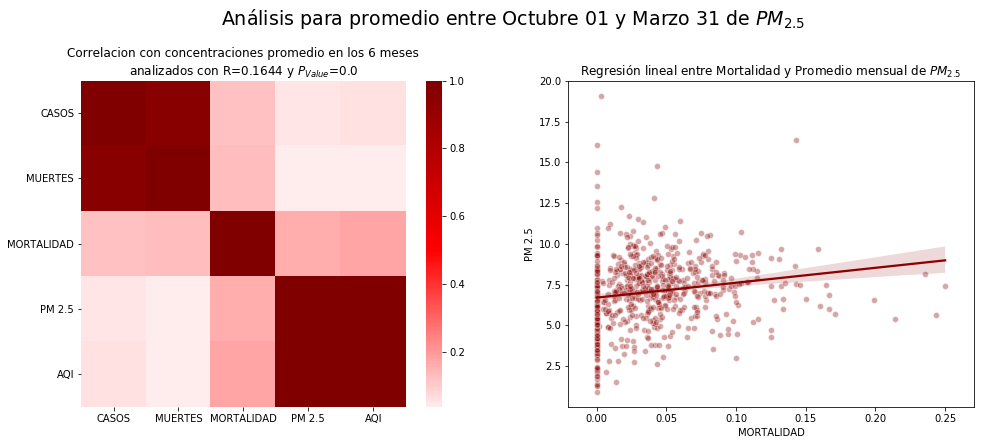

In [18]:
# Matriz de correlacion para promedio de los 6 meses (OCTUBRE NOVIEMBRE DICIEMBRE ENERO FEBRERO Y MARZO) Eliminando casos con mortalidad >= 1

fig = plt.figure(figsize=(16,6))
plt.suptitle('Análisis para promedio entre Octubre 01 y Marzo 31 de $PM_{2.5}$',y=1.05, fontsize=19)

R, PVal = scipy.stats.pearsonr(COVyPM6Month[COVyPM6Month.MORTALIDAD<1].groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)['MORTALIDAD']
                               ,COVyPM6Month[COVyPM6Month.MORTALIDAD<1].groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)['PM 2.5']) 

plt.subplot(121)
plt.title('Correlacion con concentraciones promedio en los 6 meses\nanalizados con R='+str(round(R,4))+' y $P_{Value}$=' + str(round(PVal,4)))

(sns.heatmap(COVyPM6Month[COVyPM6Month.MORTALIDAD<1].groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)
    .corr(),
    cmap = 'seismic',
    center=0))

plt.subplot(122)
plt.title('Regresión lineal entre Mortalidad y Promedio mensual de $PM_{2.5}$')
sns.regplot(COVyPM6Month[COVyPM6Month.MORTALIDAD<1].groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)['MORTALIDAD']
            ,COVyPM6Month[COVyPM6Month.MORTALIDAD<1].groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)['PM 2.5']
            ,color='darkred',scatter_kws=dict(alpha=0.35,edgecolor='white')
            ,ci=90)


print(COVyPM6Month.groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1).head())

fig.savefig('Matriz de correlación y regresion lineal SEMESTRAL '+str(date.today())+'.png',dpi=200)

                 CASOS  MUERTES  MORTALIDAD    PM 2.5        AQI
Estado  Condado                                                 
Alabama Baldwin  224.0      6.0    0.026786  6.820278  28.188889
        Clay      27.0      1.0    0.037037  6.198333  25.616667
        DeKalb   158.0      2.0    0.012658  6.478056  27.138889
        Etowah   193.0     10.0    0.051813  8.142130  32.487037
        Houston  107.0      4.0    0.037383  7.260833  30.041667


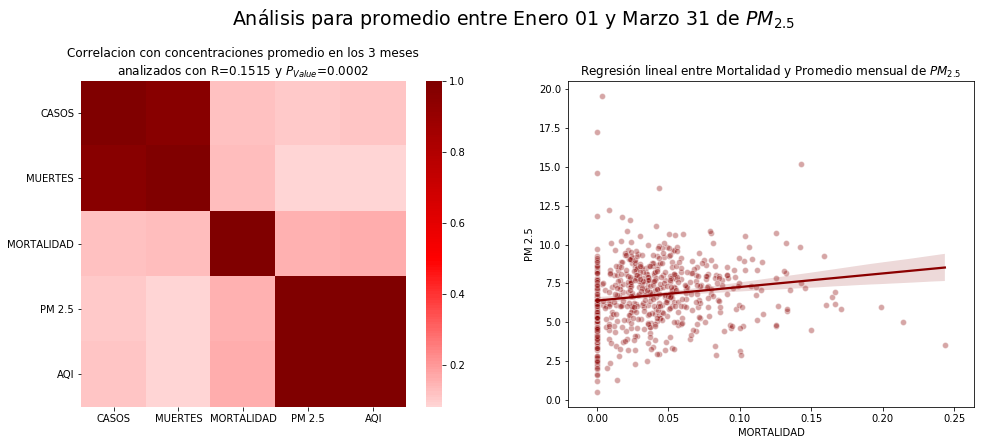

In [19]:
# Matriz de correlacion para promedio de los 3 meses (ENERO FEBRERO Y MARZO) Eliminando casos con mortalidad >= 1

fig = plt.figure(figsize=(16,6))
plt.suptitle('Análisis para promedio entre Enero 01 y Marzo 31 de $PM_{2.5}$',y=1.05, fontsize=19)

R, PVal = scipy.stats.pearsonr(COVyPM3Month[COVyPM3Month.MORTALIDAD<1].groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)['MORTALIDAD']
                               ,COVyPM3Month[COVyPM3Month.MORTALIDAD<1].groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)['PM 2.5']) 

plt.subplot(121)
plt.title('Correlacion con concentraciones promedio en los 3 meses\nanalizados con R='+str(round(R,4))+' y $P_{Value}$=' + str(round(PVal,4)))

(sns.heatmap(COVyPM3Month[COVyPM3Month.MORTALIDAD<1].groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)
    .corr(),
    cmap = 'seismic',
    center=0))

plt.subplot(122)
plt.title('Regresión lineal entre Mortalidad y Promedio mensual de $PM_{2.5}$')
sns.regplot(COVyPM3Month[COVyPM3Month.MORTALIDAD<1].groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)['MORTALIDAD']
            ,COVyPM3Month[COVyPM3Month.MORTALIDAD<1].groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)['PM 2.5']
            ,color='darkred',scatter_kws=dict(alpha=0.35,edgecolor='white')
            ,ci=90)


print(COVyPM6Month.groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1).head())

fig.savefig('Matriz de correlación y regresion lineal TRIMESTRAL '+str(date.today())+'.png',dpi=200)


# **Correlación espacio-temporal**
#### Hipótesis: La Mortalidad en cada condado en un día $y$ es mayor si la concentración de PM2.5 en el día $y-x$ es mayor.COVyPM6Month

In [20]:
# Intervalo de dias entre Mortalidad y COVID
DiasAntesPM = 60

## Datos diarios de $PM_{2.5}$

In [21]:
Directorio = 'DatosPM2.5/'
almacenarVar = False

PM25Dia = pd.DataFrame()
for i in range(51):
            
    #Lectura para datos promedios diarios para cada condado
    PMC = (pd.read_csv(Directorio+'ad_viz_plotval_data ('+str(i+1)+').csv')
           .set_index(['STATE','COUNTY'])[['Date','Daily Mean PM2.5 Concentration']])
    
    dias = []
    for i in pd.to_datetime(PMC['Date']):
        dias.append((i-np.datetime64('2020-01-01')).days)
    
    PMC['Dias desde 01/01/2020'] = dias
    
    PM25Dia = PM25Dia.append(PMC)
    
    # Paso opcional por si se quiere almacenar en variables diferentes cada información por estado
    if almacenarVar:
        estado = str(PMC.index[0][0])
        estado = estado.split()
        if len(estado)>1:
            estado = [estado[0]+'_'+estado[1]]
        estado = estado[0]
        globals()['PM_%s'%estado]=PMC
    
    
    
PM25Dia = PM25Dia.reset_index()
PM25Dia.head()

,STATE,COUNTY,Date,Daily Mean PM2.5 Concentration,Dias desde 01/01/2020
0,Alabama,Jefferson,01/01/2020,5.4,0
1,Alabama,Jefferson,01/02/2020,5.9,1
2,Alabama,Jefferson,01/03/2020,5.5,2
3,Alabama,Jefferson,01/04/2020,5.3,3
4,Alabama,Jefferson,01/05/2020,5.4,4


## Datos Mortalidad COVID-19 Diarios

In [22]:
# Limpieza de datos para obtenes solo casos dentro de estados federales 
COVCasesD = pd.DataFrame(cvaCUS.dropna().set_index(['Province_State','Admin2']))
# COVCases.columns = ['CASOS']

COVDeathsD = pd.DataFrame(cvaDUS.dropna().set_index(['Province_State','Admin2']))
# COVDeaths.columns = ['MUERTES']

COVDeathsD = COVDeathsD.iloc[:, 10:]
COVCasesD = COVCasesD.iloc[:, 9:]

dias=[]
for i in range(len(COVDeathsD.T)):
    dias.append(str((pd.to_datetime(COVDeathsD.T.index[i]) - np.datetime64('2020-01-01')).days))
    
MortalidadPerCountyDay = COVDeathsD/COVCasesD
MortalidadPerCountyDay.columns = dias

# Eliminar datos que categorizados como 'Unassigned' y 
MortalidadPerCountyDay = MortalidadPerCountyDay.drop('Unassigned', level='Admin2')

# print('Las columnas representan los dias desde el 01-01-2020')

Estado = []
Condado = []
Dia = []
Mortalidad = []

for i in range(len(MortalidadPerCountyDay)):
    for j in range(len(MortalidadPerCountyDay.T)):
        Estado.append(MortalidadPerCountyDay.index[i][0])
        Condado.append(MortalidadPerCountyDay.index[i][1])
        Dia.append(MortalidadPerCountyDay.T.index[j])
        Mortalidad.append(MortalidadPerCountyDay.iloc[i,j])

PMStateCountyMort = pd.DataFrame()
PMStateCountyMort['Estado'] = Estado
PMStateCountyMort['Condado'] = Condado
PMStateCountyMort['Dias desde 1/1/2020'] = pd.to_numeric(Dia)
PMStateCountyMort['Mortalidad'] = pd.to_numeric(Mortalidad)
PMStateCountyMort[str(DiasAntesPM) + 'dias antes'] = PMStateCountyMort['Dias desde 1/1/2020']-DiasAntesPM

PMStateCountyMort.dropna(inplace=True)

In [23]:
PMStateCountyMort[PMStateCountyMort[str(DiasAntesPM)+'dias antes']>0]

,Estado,Condado,Dias desde 1/1/2020,Mortalidad,60dias antes
62,Alabama,Autauga,83,0.0,23
63,Alabama,Autauga,84,0.0,24
64,Alabama,Autauga,85,0.0,25
65,Alabama,Autauga,86,0.0,26
66,Alabama,Autauga,87,0.0,27
...,...,...,...,...,...
353713,Utah,Out of UT,88,0.0,28
353714,Utah,Out of UT,89,0.0,29
353715,Utah,Out of UT,90,0.0,30
353716,Utah,Out of UT,91,0.0,31


## Union datos PM dias antes y mortalidad COVID actual y calculo de correlacion

In [24]:
DataCorSpaceAndTime = (pd.merge(PM25Dia, PMStateCountyMort, how = 'inner', left_on=['STATE','COUNTY','Dias desde 01/01/2020'], right_on = ['Estado','Condado',str(DiasAntesPM)+'dias antes'])
                       .drop(['STATE','COUNTY','Date',str(DiasAntesPM)+'dias antes'], axis=1)
                       .set_index(['Estado','Condado']))

DataCorSpaceAndTime.columns =['PM2.5 '+str(DiasAntesPM)+' dias antes','Dias desde 01/01/2020 PM 2.5','Dias desde 01/01/2020 COVID','Mortalidad']


# Elimino todos las celdas en donde 
DataCorSpaceAndTime = DataCorSpaceAndTime.replace([np.inf, -np.inf], np.nan).dropna()

# Cambio valores de PM2.5 negativos por 0
DataCorSpaceAndTime[DataCorSpaceAndTime['PM2.5 '+str(DiasAntesPM)+' dias antes'] < 0] = 0

# Agrupo todas las mediciones de diferentes estaciones dentro de un mismo condado en una medicion promedio diario
DataCorSpaceAndTime = DataCorSpaceAndTime.groupby([DataCorSpaceAndTime.index,'Dias desde 01/01/2020 COVID']).mean()

# Calculo de valores de asociacion estadistica
R, Pvalue = scipy.stats.pearsonr(DataCorSpaceAndTime.Mortalidad, DataCorSpaceAndTime['PM2.5 '+str(DiasAntesPM)+' dias antes'])
print(scipy.stats.kendalltau(DataCorSpaceAndTime.Mortalidad, DataCorSpaceAndTime['PM2.5 '+str(DiasAntesPM)+' dias antes']))
print(scipy.stats.spearmanr(DataCorSpaceAndTime.Mortalidad, DataCorSpaceAndTime['PM2.5 '+str(DiasAntesPM)+' dias antes']))
print('Análisis con datos de PM2.5 medidos '+str(DiasAntesPM)+' dias antes\nDatos:',str(len(DataCorSpaceAndTime)),'\nR:',R,'\nP_Value:',Pvalue)

KendalltauResult(correlation=0.07237882327190218, pvalue=4.244290255605213e-69)
SpearmanrResult(correlation=0.10219938540240425, pvalue=2.686228885481449e-69)
Análisis con datos de PM2.5 medidos 60 dias antes
Datos: 29488 
R: 0.018329316816228097 
P_Value: 0.0016458629786342775


# NO se evidencia una asociacion clara espacio-temporal

# Ensayos GLM con $Statsmodels$

In [58]:
import statsmodels.api as sm

In [59]:
sm.GLM(np.array(COVyPM3Month[COVyPM3Month.MORTALIDAD<1].groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)['MORTALIDAD']),
      np.array([COVyPM3Month[COVyPM3Month.MORTALIDAD<1].groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)['PM 2.5'],COVyPM3Month[COVyPM3Month.MORTALIDAD<1].groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)['AQI']]).T).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  596
Model:                            GLM   Df Residuals:                      594
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                       0.0013756
Method:                          IRLS   Log-Likelihood:                 1118.8
Date:                Tue, 12 May 2020   Deviance:                      0.81709
Time:                        10:19:09   Pearson chi2:                    0.817
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0187      0.005     -3.470      0.001      -0.029      -0.008
x2             0.0060      0.001      4.516      0.000       0.003       0.009
==============================================================================
"""